In [104]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp

import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from collections import defaultdict
from typing import Sequence, List, Union, Tuple, Dict, Any

from scipy.stats import entropy

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('seaborn-v0_8-whitegrid')

In [163]:
ENV_NAME = 'CartPole-v0'
STATE_BOUNDS = np.array([2.4, 2.5, 0.21, 2.5])
GAMMA = 0.999
BATCH_SIZE = 10
N_EPISODES = 1000
N_QUBITS = 4
N_LAYERS = 5
N_ACTIONS = 2
QUBITS = list(range(N_QUBITS))

N_BINS = 50
PQC_CASES_TO_RUN = [
    ("default", 5),
    ("shallow", 1),
    ("deep_BP", 10),
]
BIN_COUNTS_TO_TEST = [2, 5, 10, 20, 50]

In [164]:
def get_pqc_config(qubits, n_layers, case="default") :
    n_qubits = len(qubits)

    if case == "shallow" :
        n_layers_new = 1
    elif case == "deep_BP" :
        n_layers_new = 10
    else :
        n_layers_new = n_layers

    pauli_string = 'Z' * n_qubits
    observables = [SparsePauliOp.from_list([(pauli_string, 1.0)])]

    return n_layers_new, observables

In [165]:
def compute_full_gradient_norm(model: torch.nn.Module) -> float :
    total_norm = 0.0

    for p in model.parameters() :
        if p.grad is not None :
            total_norm += torch.linalg.norm(p.grad)**2

    if hasattr(model.pqc.qnn_torch, 'weight') and model.pqc.qnn_torch.weight.grad is not None :
        total_norm += torch.linalg.norm(model.pqc.qnn_torch.weight.grad) ** 2

    return torch.sqrt(total_norm).item()

In [166]:
def compute_action_entropy(actions: np.ndarray, n_actions: int) -> float :
    hist_a, _ = np.histogram(
        actions,
        bins=n_actions,
        range=[-0.5, n_actions - 0.5],
        density=True
    )
    p_a = hist_a
    p_a_safe = p_a[p_a > 0]

    h_a = entropy(p_a_safe, base=np.e)

    return h_a

In [167]:
def discretize_returns(returns: np.ndarray, n_bins: int) -> np.ndarray :
    min_y, max_y = np.min(returns), np.max(returns)
    if min_y == max_y : 
        return np.zeros_like(returns, dtype=int)

    bins = np.linspace(min_y, max_y, n_bins + 1)

    y_tilde = np.digitize(returns, bins[:-1]) - 1
    y_tilde[y_tilde == n_bins] = n_bins - 1

    return y_tilde

In [168]:
def compute_mi_tet_proxy(actions: np.ndarray, y_tilde: np.ndarray, n_actions: int, n_bins: int) -> float :
    hist_joint, _, _ = np.histogram2d(
        actions,
        y_tilde,
        bins=(n_actions, n_bins),
        range=[[-0.5, n_actions - 0.5], [-0.5, n_bins - 0.5]],
        density=True
    )
    p_joint = hist_joint.flatten()

    p_a = np.sum(hist_joint, axis=1)
    p_y = np.sum(hist_joint, axis=0)

    p_a_safe = p_a[p_a > 0]
    p_y_safe = p_y[p_y > 0]
    p_joint_safe = p_joint[p_joint > 0]
    
    h_a = entropy(p_a_safe, base=np.e)
    h_y = entropy(p_y_safe, base=np.e)
    h_joint = entropy(p_joint_safe, base=np.e)

    mi = h_a + h_y - h_joint

    return mi if mi > 0 else 0.0

In [169]:
def compute_expressivity(actions_per_episode: List[np.ndarray], n_actions: int) -> float :
    num_episodes = len(actions_per_episode)
    if num_episodes == 0 :
        return 0.0

    prob_A_given_Z = []
    all_actions = np.concatenate(actions_per_episode)

    for actions in actions_per_episode :
        hist, _ = np.histogram(actions, bins=n_actions, range=[-0.5, n_actions - 0.5], density=True)
        prob_A_given_Z.append(hist)

    hist_A, _ = np.histogram(all_actions, bins=n_actions, range=[-0.5, n_actions - 0.5], density=True)
    prob_A = hist_A

    total_expr = 0.0
    w = 1.0 / num_episodes

    for p_i in prob_A_given_Z :
        p_i_safe = p_i + 1e-10
        p_A_safe = prob_A + 1e-10

        kl_div = np.sum(p_i * (np.log(p_i_safe) - np.log(p_A_safe)))

        total_expr += w * kl_div

    return total_expr if total_expr > 0 else 0.0

In [170]:
def one_qubit_rotation(circuit: QuantumCircuit, qubit, angles) : 
    circuit.rx(angles[0], qubit)
    circuit.ry(angles[1], qubit)
    circuit.rz(angles[2], qubit)

def entangling_layer(circuit: QuantumCircuit, qubits) :
    for q0, q1 in zip(qubits, qubits[1:]) : 
        circuit.cz(q0, q1)
    if len(qubits) != 2 :
        circuit.cz(qubits[0], qubits[-1])

In [171]:
def generate_circuit(qubits, n_layers) : 
    n_qubits = len(qubits)

    theta_vec = ParameterVector('theta', 3 * (n_layers + 1) * n_qubits)
    theta = np.asarray(theta_vec).reshape((n_layers + 1, n_qubits, 3))

    x_vec = ParameterVector('x', n_layers * n_qubits)
    x_params = np.asarray(x_vec).reshape((n_layers, n_qubits))

    qc = QuantumCircuit(n_qubits)

    for l in range(n_layers) :
        for i, q in enumerate(qubits) :
            one_qubit_rotation(qc, q, theta[l, i])
        entangling_layer(qc, qubits)
        for i, q in enumerate(qubits) :
            qc.rx(x_params[l, i], q)

    for i, q in enumerate(qubits) :
        one_qubit_rotation(qc, q, theta[n_layers, i])

    return qc, list(theta_vec), list(x_vec)

In [172]:
class ReUploadingPQC(nn.Module) : 
    def __init__(
        self,
        qubits,
        n_layers,
        observables,
        activation: str = 'linear',
    ) : 
        super().__init__()
        self.n_layers = n_layers
        self.n_qubits = len(qubits)

        circuit, theta_params, x_params = generate_circuit(qubits, n_layers)
        if observables is None : 
            pauli_string = 'Z' * self.n_qubits
            observables = [SparsePauliOp.from_list([(pauli_string, 1.0)])]

        qnn = EstimatorQNN(
            circuit=circuit,
            observables=observables,
            input_params=x_params,
            weight_params=theta_params,
        )

        self.qnn_torch = TorchConnector(qnn)
        self.qnn = qnn

        lambda_init = torch.ones(self.n_qubits * self.n_layers, dtype=torch.float32)
        self.lmbd = nn.Parameter(lambda_init)

        self.activation = activation.lower()

    def forward(self, x: torch.Tensor) -> torch.Tensor : 
        x_tiled = x.repeat(1, self.n_layers)
        scaled = x_tiled * self.lmbd
        if self.activation != 'linear' : 
            scaled = getattr(F, self.activation)(scaled)
        return self.qnn_torch(scaled)

In [173]:
class Alternating(nn.Module) :
    def __init__(self, output_dim: int) :
        super().__init__()

        init = torch.tensor([(-1.) ** i for i in range(output_dim)], dtype=torch.float32).unsqueeze(0)
        self.w = nn.Parameter(init, requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return torch.matmul(x, self.w)

In [174]:
class PolicyNetwork(nn.Module) :
    def __init__(
        self, 
        qubits: Sequence[int],
        n_layers: int,
        n_actions: int,
        beta: float,
        observables,
        activation: str = 'linear',
    ) :
        super().__init__()
        self.pqc = ReUploadingPQC(
            qubits=qubits,
            n_layers=n_layers,
            observables=observables,
            activation=activation,
        )
        self.alt = Alternating(n_actions)
        self.beta = beta
        self.smax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        z = self.pqc(x)
        z = self.alt(z)
        z = z * self.beta
        return self.smax(z)

In [175]:
def gather_episodes(
    state_bounds: Sequence[float],
    n_actions: int,
    model: torch.nn.Module,
    n_episodes: int,
    env_name: str,
    device: torch.device | str = 'cpu',
) : 
    trajectories = [defaultdict(list) for _ in range(n_episodes)]
    envs = [gym.make(env_name) for _ in range(n_episodes)]
    done = [False] * n_episodes
    states = []
    for env in envs :
        reset_out = env.reset()
        state = reset_out[0] if isinstance(reset_out, tuple) else reset_out
        states.append(state)
 
    state_bounds = np.asarray(state_bounds, dtype=np.float32)
    model.eval()

    while not all(done) :
        unfinished_ids = [i for i, d in enumerate(done) if not d]

        normalized_states = np.stack([
            states[i] / state_bounds for i in unfinished_ids
        ]).astype(np.float32)

        for idx, norm_s in zip(unfinished_ids, normalized_states) :
            trajectories[idx]['states'].append(norm_s)

        with torch.no_grad() :
            state_tensor = torch.from_numpy(normalized_states).to(device)
            action_probs = model(state_tensor)
            probs_np = action_probs.cpu().numpy()

        for idx, prob in zip(unfinished_ids, probs_np) :
            action = np.random.choice(n_actions, p=prob)

            new_state, reward, terminated, truncated, _ = envs[idx].step(action)
            done[idx] = terminated or truncated
            states[idx] = new_state

            trajectories[idx]['actions'].append(action)
            trajectories[idx]['rewards'].append(reward)

    for env in envs :
        env.close()

    return trajectories

In [176]:
def compute_returns(rewards_history, gamma) :
    returns = []
    discounted_sum = 0.0
    for r in rewards_history[::-1] :
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)

    returns = np.array(returns)
    returns = (returns - np.mean(returns)) / (np.std(returns) + 1e-8)
    returns = returns.tolist()

    return returns

In [177]:
def REINFORCE_update(
    states: Union[Sequence, torch.Tensor],
    actions: Union[Sequence, torch.Tensor],
    returns: Union[Sequence, torch.Tensor],
    model: torch.nn.Module,
    optimizers: Tuple[torch.optim.Optimizer, torch.optim.Optimizer, torch.optim.Optimizer],
    device: torch.device | str = 'cpu',
) -> Tuple[float, float, float] :
    opt_in, opt_var, opt_out = optimizers
    model.train()

    states = torch.as_tensor(states, dtype=torch.float32, device=device)
    actions = torch.as_tensor(actions, dtype=torch.long, device=device)
    returns = torch.as_tensor(returns, dtype=torch.float32, device=device)

    probs = model(states)

    log_probs = torch.log(probs + 1e-10)
    entropy_per_state = -torch.sum(probs * log_probs, dim=1)
    avg_policy_entropy = entropy_per_state.mean().item()
    
    batch_idx = torch.arange(actions.size(0), device=device)
    p_a = probs[batch_idx, actions]

    log_p = torch.log(p_a + 1e-10)
    loss = -(log_p * returns).mean()

    for opt in (opt_in, opt_var, opt_out) : 
        opt.zero_grad()

    loss.backward()

    grad_norm = compute_full_gradient_norm(model)

    for opt in (opt_in, opt_var, opt_out) : 
        opt.step()

    return loss.item(), grad_norm, avg_policy_entropy

In [178]:
def simulate_learning(
    pqc_config: Tuple[str, int],
    state_bounds, n_actions, env_name, gamma,
    batch_size, n_episodes, n_bins, qubits,
) -> Dict[str, Any] :
    case_name, n_layers_override = pqc_config
    n_layers_current, observables = get_pqc_config(qubits, n_layers_override, case_name)

    BETA_START = 1.0
    BETA_END = 1.5
    TOTAL_BATCHES = N_EPISODES // BATCH_SIZE
    
    model = PolicyNetwork(qubits=qubits, n_layers=n_layers_current, n_actions=n_actions, beta=BETA_START, observables=observables).to('cpu')

    params_in = [model.pqc.lmbd]
    params_var = [model.pqc.qnn_torch.weight]
    params_out = list(model.alt.parameters())

    optimizer_in = torch.optim.Adam(params_in, lr=0.1, amsgrad=True)
    optimizer_var = torch.optim.Adam(params_var, lr=0.01, amsgrad=True)
    optimizer_out = torch.optim.Adam(params_out, lr=0.1, amsgrad=True)

    episode_reward_history, mi_tet_history, expr_history, grad_norm_history, entropy_history = (
        [], [], [], [], [],
    )
    batch_avg_reward_history = []
    first_batch_actions, first_batch_returns = None, None

    for batch in range(TOTAL_BATCHES) :
        progress = batch / (TOTAL_BATCHES - 1) if TOTAL_BATCHES > 1 else 1.0
        current_beta = BETA_START + (BETA_END - BETA_START) * progress

        model.beta = current_beta
        
        episodes = gather_episodes(STATE_BOUNDS, N_ACTIONS, model, BATCH_SIZE, ENV_NAME)
        states = np.concatenate([np.asarray(ep['states']) for ep in episodes])
        actions = np.concatenate([np.asarray(ep['actions']) for ep in episodes])
        returns = np.concatenate(
            [compute_returns(ep['rewards'], GAMMA) for ep in episodes]
        ).astype(np.float32)

        if batch == 0 :
            first_batch_actions = actions
            first_batch_returns = returns

        y_tilde = discretize_returns(returns, N_BINS)
        mi_tet_val = compute_mi_tet_proxy(actions, y_tilde, N_ACTIONS, N_BINS)
        mi_tet_history.append(mi_tet_val)

        actions_per_episode = [np.asarray(ep['actions']) for ep in episodes]
        expr_val = compute_expressivity(actions_per_episode, N_ACTIONS)
        expr_history.append(expr_val)

        #entropy_val = compute_action_entropy(actions, n_actions)
        #entropy_history.append(entropy_val)
        
        loss, grad_norm_val, policy_entropy_val = REINFORCE_update(states, actions, returns, model, optimizers=(optimizer_in, optimizer_var, optimizer_out))
        grad_norm_history.append(grad_norm_val)
        entropy_history.append(policy_entropy_val)

        for ep in episodes : 
            episode_reward_history.append(np.sum(ep['rewards']))
    
        avg_rewards = np.mean(episode_reward_history[-10:])
        batch_avg_reward_history.append(avg_rewards)
    
        print('Finished episode', (batch + 1) * BATCH_SIZE, 'Average rewards:', avg_rewards, 'MI-TET:', mi_tet_val, 'Expr:', expr_val, 'Grad Norm:', grad_norm_val, 'Entropy:', policy_entropy_val, 'Beta:', current_beta)
    
        if avg_rewards >= 200.0 : 
            print('Solved!')
            break

        PATIENCE_WINDOW = 10

        if len(batch_avg_reward_history) >= PATIENCE_WINDOW :
            recent_window = batch_avg_reward_history[-PATIENCE_WINDOW:]

            half_point = PATIENCE_WINDOW // 2
            first_half_avg = np.mean(recent_window[:half_point])
            second_half_avg = np.mean(recent_window[half_point:])

            if second_half_avg < first_half_avg :
                print("\n--- 학습 실패 : 조기 종료 ---")
                print(f"최근 {PATIENCE_WINDOW} 배치의 보상 추세가 감소했습니다.")
                print(f"     (이전 5개 배치 평균: {first_half_avg:.2f} -> 최근 5개 배치 평균: {second_half_avg:.2f}")
                break

    return {
        'rewards': episode_reward_history,
        'mi-tet': mi_tet_history,
        'expr': expr_history,
        'grad_norm': grad_norm_history,
        'entropy': entropy_history,
        'first_batch_actions': first_batch_actions,
        'first_batch_returns': first_batch_returns,
        'case_name': case_name
    }

In [179]:
def add_trend_and_band(ax, x, y, color, label, window=5, alpha=0.2) :
    y_series = pd.Series(y)

    y_mean = y_series.rolling(window=window, min_periods=1).mean()
    y_std = y_series.rolling(window=window, min_periods=1).std().fillna(0)

    ax.plot(x, y, 'o', color=color, alpha=0.15, markersize=3)
    ax.plot(x, y_mean, '-', color=color, label=label, linewidth=2)
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=alpha)

In [180]:
def plot_mi_tet_dynamics(history: Dict[str, Any], window=5) :
    episodes_batch = np.arange(1, len(history['mi-tet']) + 1) * BATCH_SIZE
    case_name = history['case_name']
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_left = "tab:blue"
    ax1.set_xlabel("Episode (Batch)", fontsize=12)
    ax1.set_ylabel("$I(A;\\tilde{Y})$ (MI-TET Proxy)", color=color_left, fontweight="bold", fontsize=12)

    add_trend_and_band(ax1, episodes_batch, history["mi-tet"], color_left, label="$I(A;\\tilde{Y})$ (Rolling)", window=window)

    ax1.tick_params(axis="y", labelcolor=color_left)
    ax1.grid(True, linestyle=":", alpha=0.6)

    ax2 = ax1.twinx()
    color_right = "tab:orange"
    ax2.set_ylabel("$\\mathbb{E}[H(A|S)]$ (Policy Entropy)", color=color_right, fontweight="bold", fontsize=12)

    add_trend_and_band(ax2, episodes_batch, history["entropy"], color_right, label="$\\mathbb{E}[H(A|S)]$ (Rolling)", window=window)

    ax2.tick_params(axis="y", labelcolor=color_right)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper center", frameon=True, fontsize=10)

    plt.title(f"Exploration/Exploitation Dynamics ({case_name})", fontsize=14, pad=15)
    plt.tight_layout()

    plt.savefig(f"dynamics_{case_name}.png")
    plt.close()

def plot_b_sensitivity(sensitivity_data: List[Tuple[int, float]], case_name: str) :
    Bs, mi_tets = zip(*sensitivity_data)
    
    plt.figure(figsize=(8, 5))
    plt.bar(Bs, mi_tets, width=5)
    plt.xlabel("Bin Count (B)")
    plt.ylabel("$I(A;\\tilde{Y})$ (MI-TET Proxy)")
    plt.title(f"MI-TET Sensitivity to Bin Count (Data from {case_name} batch 1)")
    plt.xticks(Bs)
    plt.grid(axis='y', linestyle='--')
    plt.savefig(f'b_sensitivity_{case_name}.png')
    plt.close()

In [181]:
def plot_rewards(all_results: Dict[str, Any], window=10) :
    plt.figure(figsize=(10, 6))
    
    plot_data = {k: v for k, v in all_results.items() if k != 'B_sensitivity'}
    colors = plt.cm.viridis(np.linspace(0, 0.9, len(plot_data)))

    for i, (case_name, history) in enumerate(plot_data.items()) :
        rewards = history['rewards']
        episodes = np.arange(1, len(rewards) + 1)
        color = colors[i]

        ax = plt.gca()
        
        add_trend_and_band(ax, episodes, rewards, color, label=f'{case_name}', window=window, alpha=0.15)
        
    plt.xlabel('Episode')
    plt.ylabel(f'Reward (Moving Average ± Std Dev)')
    plt.title(f'Learning Progression Comparison: Episode Rewards (Window={window})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('all_rewards_comparison_band.png')
    plt.close()

In [182]:
def plot_grad_norm_and_expr(history: Dict[str, Any], window=5) :
    episodes_batch = np.arange(1, len(history['mi-tet']) + 1) * BATCH_SIZE
    case_name = history['case_name']
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

    # 1. MI-TET (I(A;Y|S) Proxy) vs. Expressivity (Expr)
    ax1 = axes[0]
    color_left = "tab:blue"
    ax1.set_xlabel("Episode (Batch)")
    ax1.set_ylabel("MI-TET (nats)", color=color_left, fontweight="bold")
    add_trend_and_band(ax1, episodes_batch, history["mi-tet"], color_left, label="$I(A;\\tilde{Y})$", window=window)
    ax1.tick_params(axis="y", labelcolor=color_left)
    ax1.grid(True, linestyle=":", alpha=0.6)

    ax2 = ax1.twinx()
    color_right = "tab:red"
    ax2.set_ylabel("Expressivity (nats)", color=color_right, fontweight="bold")
    add_trend_and_band(ax2, episodes_batch, history["expr"], color_right, label="Expr (JSD)", window=window)
    ax2.tick_params(axis="y", labelcolor=color_right)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

    ax1.set_title(f"MI-TET Vs. Expressivity Dynamics ({case_name})", fontsize=14)

    # 2. MI-TET (I(A;Y|S) Proxy) vs. Full Gradient Norm (||grad||)
    ax3 = axes[1]
    ax3.set_ylabel("MI-TET (nats)", color=color_left, fontweight="bold")
    mi_tet_sqrt = np.sqrt(np.array(history["mi-tet"]))
    add_trend_and_band(ax3, episodes_batch, mi_tet_sqrt, color_left, label="$\\sqrt{I(A;\\tilde{Y})}$", window=window)
    ax3.tick_params(axis="y", labelcolor=color_left)
    ax3.grid(True, linestyle=":", alpha=0.6)

    ax4 = ax3.twinx()
    color_grad = "tab:green"
    ax4.set_ylabel("Gradient Norm", color=color_grad, fontweight="bold")
    add_trend_and_band(ax4, episodes_batch, history["grad_norm"], color_grad, label="$\\Vert \\nabla \\eta \\Vert$", window=window)
    ax4.tick_params(axis="y", labelcolor=color_grad)

    lines3, labels3 = ax3.get_legend_handles_labels()
    lines4, labels4 = ax4.get_legend_handles_labels()
    ax3.legend(lines3 + lines4, labels3 + labels4, loc="upper center")

    ax3.set_title(f"MI-TET vs. Trainability Dynamics ({case_name})", fontsize=14)

    # 3. Action Entropy (H(A|S))
    ax_ent = axes[2]
    color_ent = "tab:orange"
    add_trend_and_band(ax_ent, episodes_batch, history['entropy'], color_ent, label="$H(A|S)$", window=window)
    ax_ent.set_ylabel('Entropy (nats)')
    ax_ent.set_title(f'Action Entropy Dynamics ({case_name})', fontsize=14)
    ax_ent.legend(loc='upper right')
    ax_ent.grid(True, linestyle=':')
    ax_ent.set_xlabel('Episode (Batch)')
    
    fig.suptitle(f'Empirical Verification of Theorems for {case_name}', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(f'theorems_verification_{case_name}_modified.png')
    plt.close()

In [183]:
def run_full_experiment_suite(pqc_cases, bin_counts, default_bins, **kwargs) :
    all_results = {}
    default_case_data = None

    for case_name, n_layers in pqc_cases :
        results = simulate_learning(
            pqc_config=(case_name, n_layers),
            n_bins=default_bins,
            **kwargs,
        )
        all_results[case_name] = results

        if case_name == "default" :
            default_case_data = results

    if default_case_data :
        actions = default_case_data['first_batch_actions']
        returns = default_case_data['first_batch_returns']
        sensitivity_data = []

        if actions is not None and returns is not None :
            for B in bin_counts :
                y_tilde = discretize_returns(returns, B)
                mi_tet_val = compute_mi_tet_proxy(actions, y_tilde, N_ACTIONS, B)
                sensitivity_data.append((B, mi_tet_val))

            all_results['B_sensitivity'] = sensitivity_data

    return all_results

In [184]:
if __name__ == '__main__' :
    all_results = run_full_experiment_suite(
        pqc_cases=PQC_CASES_TO_RUN,
        bin_counts=BIN_COUNTS_TO_TEST,
        default_bins=N_BINS,
        state_bounds=STATE_BOUNDS,
        n_actions=N_ACTIONS,
        env_name=ENV_NAME,
        gamma=GAMMA,
        batch_size=BATCH_SIZE,
        n_episodes=N_EPISODES,
        qubits=QUBITS,
    )
    print("\n--- All experiments finished. ---")

    plot_rewards(all_results)
    
    for case_name, result in all_results.items() :
        if case_name != 'B_sensitivity' :
            plot_mi_tet_dynamics(result)
            plot_grad_norm_and_expr(result)

    if 'B_sensitivity' in all_results :
        plot_b_sensitivity(all_results['B_sensitivity'], "default")

/var/folders/4h/nkpffcmn54v3c7rkqc6jvw9h0000gn/T/ipykernel_10350/400456141.py:18: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Finished episode 10 Average rewards: 14.6 MI-TET: 0.17336456326681038 Expr: 0.0458895676507475 Grad Norm: 0.13404834270477295 Entropy: 0.6029096245765686 Beta: 1.0
Finished episode 20 Average rewards: 16.2 MI-TET: 0.16086555409220704 Expr: 0.0279749564704096 Grad Norm: 0.12747372686862946 Entropy: 0.6241759657859802 Beta: 1.005050505050505
Finished episode 30 Average rewards: 26.6 MI-TET: 0.09483124544264587 Expr: 0.008541195589772435 Grad Norm: 0.24188390374183655 Entropy: 0.6549254059791565 Beta: 1.0101010101010102
Finished episode 40 Average rewards: 18.5 MI-TET: 0.14581114559169706 Expr: 0.05429657224929109 Grad Norm: 0.15592780709266663 Entropy: 0.6759730577468872 Beta: 1.0151515151515151
Finished episode 50 Average rewards: 20.3 MI-TET: 0.12034451497093279 Expr: 0.03695719798577865 Grad Norm: 0.08746003359556198 Entropy: 0.673054575920105 Beta: 1.02020202020202
Finished episode 60 Average rewards: 22.1 MI-TET: 0.12670758280583083 Expr: 0.024717120356472156 Grad Norm: 0.1420522332

In [185]:
print(all_results)

{'default': {'rewards': [np.float64(10.0), np.float64(11.0), np.float64(11.0), np.float64(14.0), np.float64(17.0), np.float64(16.0), np.float64(15.0), np.float64(26.0), np.float64(15.0), np.float64(11.0), np.float64(29.0), np.float64(12.0), np.float64(11.0), np.float64(9.0), np.float64(9.0), np.float64(16.0), np.float64(44.0), np.float64(11.0), np.float64(10.0), np.float64(11.0), np.float64(31.0), np.float64(21.0), np.float64(19.0), np.float64(32.0), np.float64(18.0), np.float64(28.0), np.float64(22.0), np.float64(29.0), np.float64(16.0), np.float64(50.0), np.float64(18.0), np.float64(15.0), np.float64(32.0), np.float64(25.0), np.float64(9.0), np.float64(30.0), np.float64(17.0), np.float64(10.0), np.float64(19.0), np.float64(10.0), np.float64(12.0), np.float64(10.0), np.float64(50.0), np.float64(20.0), np.float64(34.0), np.float64(24.0), np.float64(11.0), np.float64(19.0), np.float64(13.0), np.float64(10.0), np.float64(14.0), np.float64(14.0), np.float64(14.0), np.float64(55.0), np.flo

In [131]:
plot_rewards(all_results)
    
for case_name, result in all_results.items() :
    if case_name != 'B_sensitivity' :
        plot_mi_tet_dynamics(result)
        plot_grad_norm_and_expr(result)

if 'B_sensitivity' in all_results :
    plot_b_sensitivity(all_results['B_sensitivity'], "default")

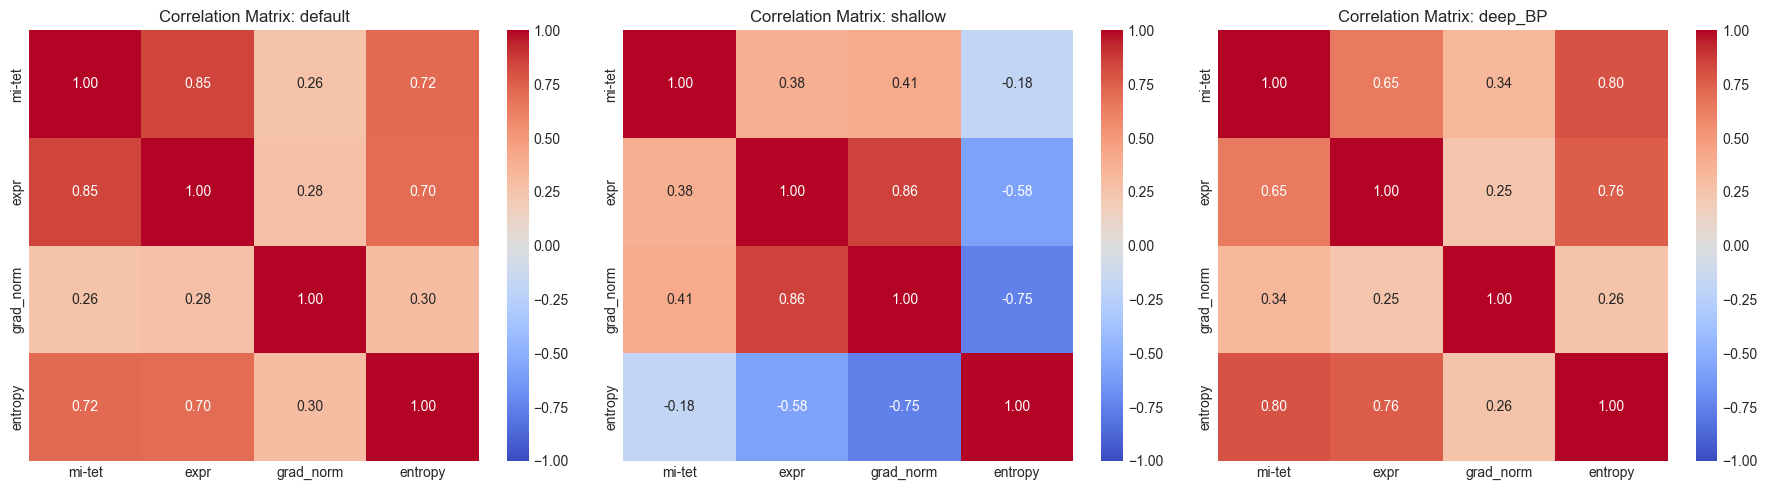

In [186]:
import seaborn as sns

target_cases = ['default', 'shallow', 'deep_BP']
target_metrics = ['mi-tet', 'expr', 'grad_norm', 'entropy']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, case_name in enumerate(target_cases) :
    case_data = all_results[case_name]
    
    filtered_data = {k: case_data[k] for k in target_metrics if k in case_data}

    df = pd.DataFrame(filtered_data)

    corr_matrix = df.corr(method='pearson')

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[i], fmt='.2f')
    axes[i].set_title(f'Correlation Matrix: {case_name}')

plt.tight_layout()
plt.show()